# Data Science Development Series - NLP 101

The content in this notebook is intended show the basics of Natural Language Processing (NLP). In this notebook we will walk through the following NLP project tasks: 
1. Exploratory Data Analysis (EDA)
2. Data Preprocessing & Cleansing
3. Feature Extraction
4. ML Model Development (Supervised Machine Learning Model)
5. Model Evaluation and Interpretation

The problem displayed in this notebook is for a news article classification task. We will leverage labeled data provided by BBC to develop a machine learning classifier to predict the category of incoming news articles. The categories (classes) in scope are:

- Business
- Entertainment
- Sports
- Politics
- Technology

The data file found in this repo has been transformed and converted to a single CSV file. The raw BBC dataset can be found on Kaggle: https://www.kaggle.com/c/learn-ai-bbc/data

h/t to Github user @miguelfzafra for sharing his project on this topic, as it inspired the content in this notebook. https://github.com/miguelfzafra/Latest-News-Classifier




## 1. Exploratory Data Analysis

We will perform a light exploratory data analysis to save time, but also because the data is relatively small.

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Hide any warnings
import warnings
warnings.filterwarnings("ignore")

Loading the dataset:

In [2]:
df = pd.read_csv("./data/bbc-news-data.csv")

In [3]:
print("This dataset contains {attributes} attributes and {records} records" 
      .format(attributes=df.shape[1],records=df.shape[0]))

This dataset contains 2 attributes and 2225 records


In [5]:
df.head()

,Content,Category
0,Ad sales boost Time Warner profit\n\nQuarterly...,business
1,Dollar gains on Greenspan speech\n\nThe dollar...,business
2,Yukos unit buyer faces loan claim\n\nThe owner...,business
3,High fuel prices hit BA's profits\n\nBritish A...,business
4,Pernod takeover talk lifts Domecq\n\nShares in...,business


### Example of the content

In [6]:
df['Content'].iloc[0]

'Ad sales boost Time Warner profit\n\nQuarterly profits at US media giant TimeWarner jumped 76% to $1.13bn (Â£600m) for the three months to December, from $639m year-earlier.\n\nThe firm, which is now one of the biggest investors in Google, benefited from sales of high-speed internet connections and higher advert sales. TimeWarner said fourth quarter sales rose 2% to $11.1bn from $10.9bn. Its profits were buoyed by one-off gains which offset a profit dip at Warner Bros, and less users for AOL.\n\nTime Warner said on Friday that it now owns 8% of search-engine Google. But its own internet business, AOL, had has mixed fortunes. It lost 464,000 subscribers in the fourth quarter profits were lower than in the preceding three quarters. However, the company said AOL\'s underlying profit before exceptional items rose 8% on the back of stronger internet advertising revenues. It hopes to increase subscribers by offering the online service free to TimeWarner internet customers and will try to si

### Distribution of articles across each category

In [7]:
df['Category'].value_counts()

sport            511
business         510
politics         417
tech             401
entertainment    386
Name: Category, dtype: int64

There is a fairly even distribution of labeled data. You can use your favorite python plotting library to make this portion of the eda more visually appealing.

### Lengths of articles

Definition of news length field. Although there are special characters in the text (``\r, \n``), it will be useful as an approximation.

In [8]:
df['News_length'] = df['Content'].str.len()

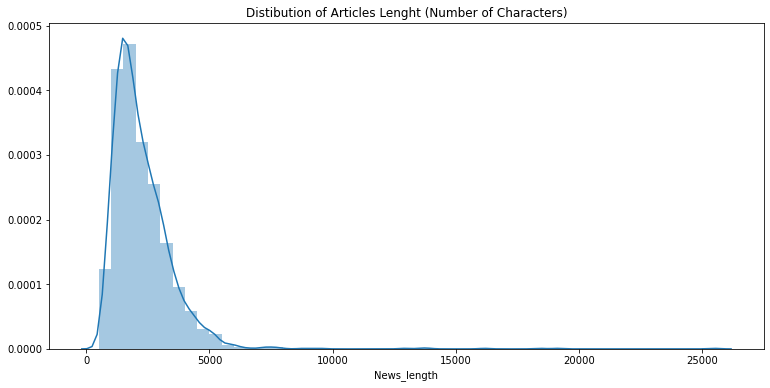

In [9]:
plt.figure(figsize=(12.8,6))
sns.distplot(df['News_length']).set_title('Distibution of Articles Length (Number of Characters)');

In [10]:
df['News_length'].describe()

count     2225.000000
mean      2264.790562
std       1364.305951
min        502.000000
25%       1447.000000
50%       1966.000000
75%       2803.000000
max      25484.000000
Name: News_length, dtype: float64

### Length of article by category

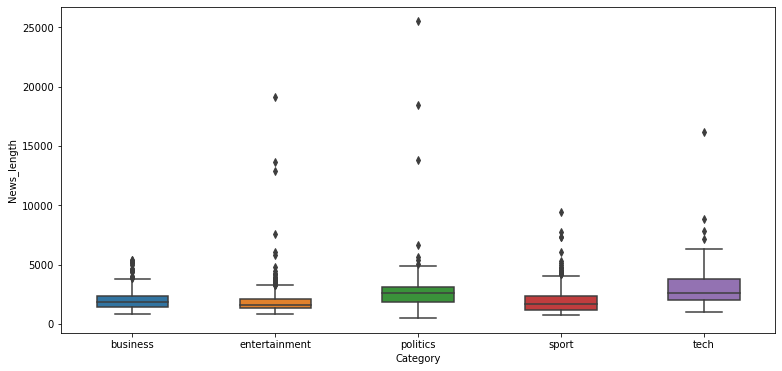

In [11]:
plt.figure(figsize=(12.8,6))
sns.boxplot(data=df, x='Category', y='News_length', width=.5);

------------
## 2. Data Preprocessing & Cleansing

In this phase we will apply some preprocessing methods we learned during the lecture:
- **Text Cleansing:** Remove punctuation, downcase all words, and remove possessive pronouns 
- **Tokenization:** Splitting sentences from paragraphs and words from the sentences.
- **Stopword Removal:** Any piece of text which is not relevant to context of data can be output can be specified as noise and removed.
- **Stemming:** Aims to identify stem form of the word and use it in lieu of the word itself (rule based stripping of suffixes from word).
- **Lemmatization:** Process of grouping together the inflected forms of a word so they can be analysed as a single item, identified by the word's lemma, or dictionary form. This is a form of morphological analysis.



In [21]:
import pandas as pd
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.stem import PorterStemmer 
from nltk.tokenize import word_tokenize 

For reference, here is the raw version of the first article in our data set again:

In [12]:
df['Content'].iloc[0]

'Ad sales boost Time Warner profit\n\nQuarterly profits at US media giant TimeWarner jumped 76% to $1.13bn (Â£600m) for the three months to December, from $639m year-earlier.\n\nThe firm, which is now one of the biggest investors in Google, benefited from sales of high-speed internet connections and higher advert sales. TimeWarner said fourth quarter sales rose 2% to $11.1bn from $10.9bn. Its profits were buoyed by one-off gains which offset a profit dip at Warner Bros, and less users for AOL.\n\nTime Warner said on Friday that it now owns 8% of search-engine Google. But its own internet business, AOL, had has mixed fortunes. It lost 464,000 subscribers in the fourth quarter profits were lower than in the preceding three quarters. However, the company said AOL\'s underlying profit before exceptional items rose 8% on the back of stronger internet advertising revenues. It hopes to increase subscribers by offering the online service free to TimeWarner internet customers and will try to si

### Remove Special Characters

We can see the following special characters:

- ``\r``
- ``\n``
- ``"`` when quoting text

In [13]:
# \r and \n
df['Content_Parsed'] = df['Content'].str.replace("\r", " ")
df['Content_Parsed'] = df['Content_Parsed'].str.replace("\n", " ")
df['Content_Parsed'] = df['Content_Parsed'].str.replace("    ", " ")

In [14]:
# " when quoting text
df['Content_Parsed'] = df['Content_Parsed'].str.replace('"', '')

### Downcase all text

We'll downcase the text to ensure all the same words are comprehended the same, no matter the case.

In [15]:
# Lowercasing the text
df['Content_Parsed'] = df['Content_Parsed'].str.lower()

### Remove punctuation signs

In [16]:
punctuation_signs = list("?:!.,;")
df['Content_Parsed'] = df['Content_Parsed']

for punct_sign in punctuation_signs:
    df['Content_Parsed'] = df['Content_Parsed'].str.replace(punct_sign, '')

### Possessive pronouns

We'll also remove possessive pronoun terminations:

In [17]:
df['Content_Parsed'] = df['Content_Parsed'].str.replace("'s", "")

Let's review that first review again:

In [18]:
df['Content_Parsed'].iloc[0]

"ad sales boost time warner profit  quarterly profits at us media giant timewarner jumped 76% to $113bn (â£600m) for the three months to december from $639m year-earlier  the firm which is now one of the biggest investors in google benefited from sales of high-speed internet connections and higher advert sales timewarner said fourth quarter sales rose 2% to $111bn from $109bn its profits were buoyed by one-off gains which offset a profit dip at warner bros and less users for aol  time warner said on friday that it now owns 8% of search-engine google but its own internet business aol had has mixed fortunes it lost 464000 subscribers in the fourth quarter profits were lower than in the preceding three quarters however the company said aol underlying profit before exceptional items rose 8% on the back of stronger internet advertising revenues it hopes to increase subscribers by offering the online service free to timewarner internet customers and will try to sign up aol existing customers

### Stemming

Example first:

In [20]:
# We imported these NLTK modules earlier
from nltk.stem import PorterStemmer 
from nltk.tokenize import word_tokenize 
   
porter_stemmer = PorterStemmer() 
  
# example words to be stemmed
words = ["program", "programs", "programer", "programing", "programers"] 
  
for w in words: 
    print(w, ": ", porter_stemmer.stem(w)) 


program :  program
programs :  program
programer :  program
programing :  program
programers :  program


<br>
Now let's stem on the entire news dataset

In [22]:
porter_stemmer = PorterStemmer() 

nrows = len(df)
stemmed_text_list = []

for row in range(0, nrows):
    
    # Create an empty list containing stemming words
    stemmed_list = []
    
    # Save the text and its words into an object
    text = df.loc[row]['Content_Parsed']
    text_words = text.split(" ")

    # Iterate through every word to stemming
    for word in text_words:
        stemmed_list.append(porter_stemmer.stem(word))
        
    # Join the list
    stemmed_text = " ".join(stemmed_list)
    
    # Append to the list containing the texts
    stemmed_text_list.append(stemmed_text)

In [23]:
df['Content_Parsed'] = stemmed_text_list

### Lemmatization

We will use Wordnet as the lexical database which allows us to complete the lemmatization task. Here is an example first:

In [24]:
# imported these modules earlier
from nltk.stem import WordNetLemmatizer 

# Need to download punkt and wordnet from NLTK
nltk.download('punkt')
nltk.download('wordnet')

[nltk_data] Downloading package punkt to /home/jupyter/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /home/jupyter/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [25]:
# Saving the lemmatizer into an object
wordnet_lemmatizer = WordNetLemmatizer() 
  
print("rocks:", wordnet_lemmatizer.lemmatize("rocks")) 
print("corpora:", wordnet_lemmatizer.lemmatize("corpora")) 
  
# a denotes adjective in "pos" 
print("better:", wordnet_lemmatizer.lemmatize("better", pos ="a")) 

rocks: rock
corpora: corpus
better: good


<br>
Now let's lemmatize on the entire news dataset

In [26]:
wordnet_lemmatizer = WordNetLemmatizer()

nrows = len(df)
lemmatized_text_list = []

for row in range(0, nrows):
    
    # Create an empty list containing lemmatized words
    lemmatized_list = []
    
    # Save the text and its words into an object
    text = df.loc[row]['Content_Parsed']
    text_words = text.split(" ")

    # Iterate through every word to lemmatize
    for word in text_words:
        lemmatized_list.append(wordnet_lemmatizer.lemmatize(word, pos="v"))
        
    # Join the list
    lemmatized_text = " ".join(lemmatized_list)
    
    # Append to the list containing the texts
    lemmatized_text_list.append(lemmatized_text)

In [27]:
df['Content_Parsed'] = lemmatized_text_list

Let's review that first review now:

In [28]:
df['Content_Parsed'].iloc[0]

"ad sale boost time warner profit  quarterli profit at us media giant timewarn jump 76% to $113bn (â£600m) for the three month to decemb from $639m year-earli  the firm which be now one of the biggest investor in googl benefit from sale of high-spe internet connect and higher advert sale timewarn say fourth quarter sale rise 2% to $111bn from $109bn it profit be buoy by one-off gain which offset a profit dip at warner bro and less user for aol  time warner say on friday that it now own 8% of search-engin googl but it own internet busi aol have ha mix fortun it lose 464000 subscrib in the fourth quarter profit be lower than in the preced three quarter howev the compani say aol underli profit befor except item rise 8% on the back of stronger internet advertis revenu it hope to increas subscrib by offer the onlin servic free to timewarn internet custom and will tri to sign up aol exist custom for high-spe broadband timewarn also ha to restat 2000 and 2003 result follow a probe by the us s

### Stop words

NLTK provides a list of stopwords that we can leverage. These are commonly used words that will impact the modeling, so we remove.

In [29]:
# Downloading the stop words list
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/jupyter/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [30]:
# Loading the stop words in english
stop_words = list(stopwords.words('english'))

In [31]:
len(stop_words)

179

In [32]:
stop_words[0:10]

['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're"]

Let's look at an example first:

In [33]:
# Imported these libraries earlier
# from nltk.corpus import stopwords 
# from nltk.tokenize import word_tokenize 
  
example = "This is a sample sentence, showing off the stop words filtration."
  
stop_words = list(stopwords.words('english'))
  
word_tokens = word_tokenize(example) 
  
filtered_sentence = [w for w in word_tokens if not w in stop_words] 
  
filtered_sentence = [] 
  
for w in word_tokens: 
    if w not in stop_words: 
        filtered_sentence.append(w) 
  
print(word_tokens) 
print(filtered_sentence) 

['This', 'is', 'a', 'sample', 'sentence', ',', 'showing', 'off', 'the', 'stop', 'words', 'filtration', '.']
['This', 'sample', 'sentence', ',', 'showing', 'stop', 'words', 'filtration', '.']


<br>
Now let's try on the full news dataset. To do this in the text string, we will have to ude regular expression:

In [34]:
df['Content_Parsed'] = df['Content_Parsed']

for stop_word in stop_words:

    regex_stopword = r"\b" + stop_word + r"\b"
    df['Content_Parsed'] = df['Content_Parsed'].str.replace(regex_stopword, '')

Let's review that first review now:

In [35]:
df['Content_Parsed'].iloc[0]

"ad sale boost time warner profit  quarterli profit  us media giant timewarn jump 76%  $113bn (â£600m)   three month  decemb  $639m year-earli   firm    one   biggest investor  googl benefit  sale  high-spe internet connect  higher advert sale timewarn say fourth quarter sale rise 2%  $111bn  $109bn  profit  buoy  one- gain  offset  profit dip  warner bro  less user  aol  time warner say  friday     8%  search-engin googl    internet busi aol  ha mix fortun  lose 464000 subscrib   fourth quarter profit  lower    preced three quarter howev  compani say aol underli profit befor except item rise 8%   back  stronger internet advertis revenu  hope  increas subscrib  offer  onlin servic free  timewarn internet custom   tri  sign  aol exist custom  high-spe broadband timewarn also ha  restat 2000  2003 result follow  probe   us secur exchang commiss (sec)   close  conclud  time warner fourth quarter profit  slightli better  analysts' expect   film divis saw profit slump 27%  $284m help  box-o

In [36]:
df.head()

,Content,Category,News_length,Content_Parsed
0,Ad sales boost Time Warner profit\n\nQuarterly...,business,2559,ad sale boost time warner profit quarterli pr...
1,Dollar gains on Greenspan speech\n\nThe dollar...,business,2251,dollar gain greenspan speech dollar ha hit ...
2,Yukos unit buyer faces loan claim\n\nThe owner...,business,1551,yuko unit buyer face loan claim owner embat...
3,High fuel prices hit BA's profits\n\nBritish A...,business,2411,high fuel price hit ba profit british airway ...
4,Pernod takeover talk lifts Domecq\n\nShares in...,business,1569,pernod takeov talk lift domecq share uk drin...


### Train - test split

We will do a 70/30 train/test split. Using sklearn's train_test_split functionality

In [37]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(df['Content_Parsed'], 
                                                    df['Category'], 
                                                    test_size=0.3, 
                                                    random_state=8)

-----------
## 3. Feature Extraction

As mentioned in the lecture, there are multiple ways methods to use text representation as features for ML models. Below are just a few:

- Bag of Words
- TF-IDF Vectors
- Count Vectors
- Word2Vec

We will use **TF-IDF Vectors** as the features for the news classification model.

Scikit Learn offers a great module to convert raw text into a matrix of TF-IDF features, called ``TfidfVectorizer``. We will leverage this module, details and parameter guide can be found here: https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html

In [38]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_selection import chi2

We have chosen these values as a first approximation. Since the models that we develop later have a very good predictive power, we'll stick to these values. But it has to be mentioned that different combinations could be tried in order to improve even more the accuracy of the models.

In [39]:
tfidf = TfidfVectorizer(encoding='utf-8',
                        ngram_range=(1,2), # to consider both unigrams and bigrams.
                        stop_words=None,   # already preprocessed with stopwords
                        lowercase=False,   # already preprocessed lowercase
                        max_df=10,         # When building dictionaty, ignore terms that have a document frequency strictly higher than the given threshold
                        min_df=1,          # When building the vocabulary, ignore terms that have a document frequency strictly lower than the given threshold
                        max_features=300,  # Build matrix that only considers 300 unigrams and bigrams ordered by term frequency across the corpus
                        norm='l2',         # l2: Sum of squares of vector elements is 1. The cosine similarity between two vectors is their dot product when l2 norm has been applied
                        sublinear_tf=True
                       )
                        


In [40]:
features_train = tfidf.fit_transform(X_train).toarray()
labels_train = y_train
print(features_train.shape)

features_test = tfidf.transform(X_test).toarray()
labels_test = y_test
print(features_test.shape)

(1557, 300)
(668, 300)


Basically, what's happening is the top 300 ngrams and bigrams of raw text by term frequency are widened out into a matrix. Then the TF-IDF is calculated by for each ngram/bigram across each news article. Creating a massive matrix that will be input into our machine learning model. 

<br> 
Let's run a Chi squared test to see which unigrams and bigrams are most correlated with each category:

In [41]:
from sklearn.feature_selection import chi2
import numpy as np

category_lst = df['Category'].unique().tolist()

for Product in category_lst:
    features_chi2 = chi2(features_train, labels_train == Product)
    indices = np.argsort(features_chi2[0])
    feature_names = np.array(tfidf.get_feature_names())[indices]
    unigrams = [v for v in feature_names if len(v.split(' ')) == 1]
    bigrams = [v for v in feature_names if len(v.split(' ')) == 2]
    print("# '{}' category:".format(Product))
    print("Most correlated unigrams:\n. {}".format('\n. '.join(unigrams[-5:])))
    print("Most correlated bigrams:\n. {}".format('\n. '.join(bigrams[-2:])))
    print("----------------")


# 'business' category:
Most correlated unigrams:
. g7
. opec
. boe
. yugansk
. eurozon
Most correlated bigrams:
. foreign firm
. retail sale
----------------
# 'entertainment' category:
Most correlated unigrams:
. osbourn
. dancer
. swank
. hank
. guitarist
Most correlated bigrams:
. scissor sister
. robbi william
----------------
# 'politics' category:
Most correlated unigrams:
. refuge
. coalit
. detaine
. referendum
. g8
Most correlated bigrams:
. mr milburn
. mr blunkett
----------------
# 'sport' category:
Most correlated unigrams:
. benitez
. dallaglio
. agassi
. rusedski
. henman
Most correlated bigrams:
. sub use
. carl cup
----------------
# 'tech' category:
Most correlated unigrams:
. bittorr
. linux
. patent
. hotspot
. domain
Most correlated bigrams:
. camera phone
. malici program
----------------


-------------
## 4. Model Development 

There are many machine learning algorithms to chose from, but for the purpose of this demostration We will show just one example: SVM (support vector machines). 

SVMs are supervised learning models with associated learning algorithms that analyze data used for classification and regression analysis. It uses a technique called the kernel trick to transform your data and then based on these transformations it finds an optimal boundary between the possible outputs. This is a great algorthim for our news article classification problem 

In [42]:
from sklearn import svm
from pprint import pprint
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.model_selection import ShuffleSplit
import matplotlib.pyplot as plt

#### Parameter Selection

Let's first check the default parameters of the the svm. They details and default parameters can also be found in the documentation: https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html


In [43]:
svc_param =svm.SVC(random_state=8)

print('Default Parameters:\n')
pprint(svc_param.get_params())

Default Parameters:

{'C': 1.0,
 'break_ties': False,
 'cache_size': 200,
 'class_weight': None,
 'coef0': 0.0,
 'decision_function_shape': 'ovr',
 'degree': 3,
 'gamma': 'scale',
 'kernel': 'rbf',
 'max_iter': -1,
 'probability': False,
 'random_state': 8,
 'shrinking': True,
 'tol': 0.001,
 'verbose': False}


<br>
Now, let's tune the parameters a bit.
<br>

**NOTE:** this process typically isnt as straight forward as selecting optimal parameters based on a hunch. Data Scientist need to perform experiments and hyperparameter tuning exercises to find the optimal mix


In [44]:
model_params = svm.SVC(C=0.01, 
                        break_ties=False,
                        cache_size=200, 
                        class_weight=None, 
                        coef0=0.0,
                        decision_function_shape='ovr', 
                        degree=4, 
                        gamma=10,     # Changed to 10
                        kernel='poly',  # Change to poly
                        max_iter=-1,      
                        probability=True, # Want to return probability
                        random_state=8,   
                        shrinking=True,   
                        tol=0.001, 
                        verbose=False)

Fit a model using defined parameters

In [45]:
svc_train = model_params.fit(features_train, labels_train)

------------
## 5. Model Evaluation & Interpretation

Predict on test dataset

In [46]:
svc_pred = svc_train.predict(features_test)

#### Test accuracy

In [47]:
# Test accuracy
print("The test accuracy is: ")
print(accuracy_score(labels_test, svc_pred))

The test accuracy is: 
0.5703592814371258


#### Classification report

In [48]:
# Classification report
print("Classification report")
print(classification_report(labels_test,svc_pred))

Classification report
               precision    recall  f1-score   support

     business       0.38      0.92      0.54       165
entertainment       0.69      0.35      0.46       109
     politics       0.84      0.42      0.56       132
        sport       0.90      0.50      0.65       143
         tech       0.90      0.54      0.67       119

     accuracy                           0.57       668
    macro avg       0.74      0.55      0.58       668
 weighted avg       0.73      0.57      0.58       668



#### Confusion matrix

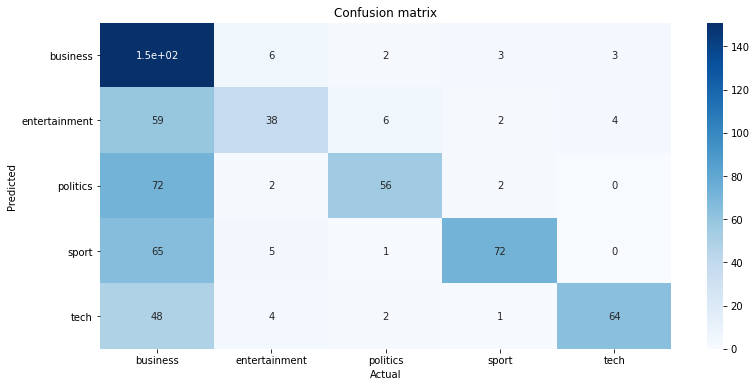

In [49]:
aux_df = df[['Category']].drop_duplicates().sort_values('Category')
conf_matrix = confusion_matrix(labels_test, svc_pred)
plt.figure(figsize=(12.8,6))
sns.heatmap(conf_matrix, 
            annot=True,
            xticklabels=aux_df['Category'].values, 
            yticklabels=aux_df['Category'].values,
            cmap="Blues")
plt.ylabel('Predicted')
plt.xlabel('Actual')
plt.title('Confusion matrix')
plt.show()

---------------------

# HOMEWORK 
**Help Me Make This Model Better!!!**

There are three different buckets of experiments that you can go through:
1. Test Different Feature Extraction Methods (Bag of Words, Word2Vec)
2. Test Different Algorithms (Random Forest, KNN, Nueral Nets)
3. Hyperparemeter Tuning (Create a Grid Search to test parameters and compare peformance) 

Commit changes to the gitlab repository:  
    